In [1]:
!nvidia-smi

Fri Aug 15 01:02:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P40                      On  |   00000000:04:00.0 Off |                    0 |
| N/A   38C    P0             57W /  250W |     151MiB /  23040MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 5, 7"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [3]:
import torch
from qwen_vl_utils import process_vision_info
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(load_in_8bit=True)
model_path = "Qwen/Qwen2.5-VL-7B-Instruct"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_path, 
    torch_dtype="auto", 
    device_map="auto",
    quantization_config=bnb_config,
)
processor = AutoProcessor.from_pretrained(
    model_path, 
    # min_pixels=256*28*28, 
    # max_pixels=1280*28*28,
)

/opt/miniconda/envs/.venv-mammography/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
import json
import random
import io
import ast
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor
import xml.etree.ElementTree as ET
additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def plot_bounding_boxes(img, bounding_boxes, input_width, input_height):

    width, height = img.size
    draw = ImageDraw.Draw(img)

    colors = [
        'red',
        'green',
        'blue',
        'yellow',
        'orange',
        'pink',
        'purple',
        'brown',
        'gray',
        'beige',
        'turquoise',
        'cyan',
        'magenta',
        'lime',
        'navy',
        'maroon',
        'teal',
        'olive',
        'coral',
        'lavender',
        'violet',
        'gold',
        'silver',
    ] + additional_colors

    bounding_boxes = parse_json(bounding_boxes)
    font = ImageFont.load_default()

    try:
        json_output = ast.literal_eval(bounding_boxes)
    except Exception as e:
        end_idx = bounding_boxes.rfind('"}') + len('"}')
        truncated_text = bounding_boxes[:end_idx] + "]"
        json_output = ast.literal_eval(truncated_text)

    for i, bounding_box in enumerate(json_output):
        color = colors[i % len(colors)]
        abs_y1 = int(bounding_box["bbox_2d"][1]/input_height * height)
        abs_x1 = int(bounding_box["bbox_2d"][0]/input_width * width)
        abs_y2 = int(bounding_box["bbox_2d"][3]/input_height * height)
        abs_x2 = int(bounding_box["bbox_2d"][2]/input_width * width)

        if abs_x1 > abs_x2:
            abs_x1, abs_x2 = abs_x2, abs_x1

        if abs_y1 > abs_y2:
            abs_y1, abs_y2 = abs_y2, abs_y1

        draw.rectangle(
            ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
        )

        if "label" in bounding_box:
            draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font)

    img.show()

def parse_json(json_output):
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  
            json_output = json_output.split("```")[0]
            break
    return json_output

In [9]:
def inference(img_url, prompt, system_prompt="You are a helpful assistant", max_new_tokens=1024):
    image = Image.open(img_url)
    messages = [
        {
            "role": "system",
            "content": system_prompt
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt
                },
                {
                    "image": img_url
                }
            ]
        }
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    print("input:\n",text)
    inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt")

    output_ids = model.generate(**inputs, max_new_tokens=512)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    print("output:\n",output_text[0])

    input_height = inputs['image_grid_thw'][0][1]*14
    input_width = inputs['image_grid_thw'][0][2]*14

    return output_text[0], input_height, input_width

In [10]:
import os
import dataset

image_annotation_tuples = dataset.load_image_annotation_tuples()
unique_tuples = list({img_path: (img_path, ann) for img_path, ann in image_annotation_tuples}.values())

save_dir = "out/qwen_25_vl_7B_instruct_ipynb"
os.makedirs(save_dir, exist_ok=True)
log_path = os.path.join(save_dir, "log.txt")

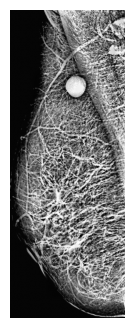

In [ ]:
import pydicom
import numpy as np
import preprocess

idx = 5
img_path, annotation = unique_tuples[idx]
folder = annotation['study_id']
os.makedirs(os.path.join(save_dir, folder), exist_ok=True)

basename = annotation['image_id']
img_png_path = os.path.join(save_dir, folder, f"{basename}.png")

ds = pydicom.dcmread(img_path)
img_arr = ds.pixel_array.astype(np.float32)

x, m, new_annotation = preprocess.crop(img_arr, annotation=annotation)
norm = preprocess.truncation_normalization(x, m)

step1 = preprocess.median_denoise(norm, disk_radius=3)
step2 = preprocess.unsharp_enhance(step1, radius=1.0, amount=1.5)
step3 = preprocess.morphological_tophat(step2, selem_radius=15)
step4 = preprocess.non_local_means_denoise(step3, patch_size=5, patch_distance=6, h_factor=0.8)
step5 = preprocess.wavelet_enhancement(step4, wavelet='db8', level=1)
final = preprocess.clahe(step5, clip_limit=0.02)
disp = preprocess.normalize_for_display(final)
disp = preprocess.
disp = np.nan_to_num(disp)

img_png_path_pre = os.path.join(save_dir, folder, f"{basename}_{idx}_preprocessed.png")
Image.fromarray(disp).save(img_png_path_pre)

import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4)) 
plt.imshow(disp, cmap='gray')
plt.axis('off')
plt.show()


In [12]:
import prompt

image_path = img_png_path_pre
prompt = "请严格标注并框选图像中所有细小、圆形的可疑肿块（Mass）或可疑钙化灶（Suspicious Calcification）区域，输出对应的检测框坐标，以便后续诊断分析, 检测框应紧贴所检测到的目标。"
response, input_height, input_width = inference(image_path, prompt)

image = Image.open(image_path)
print(image.size)

input:
 <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
请严格标注并框选图像中所有细小、圆形的可疑肿块（Mass）或可疑钙化灶（Suspicious Calcification）区域，输出对应的检测框坐标，以便后续诊断分析, 检测框应紧贴所检测到的目标。<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant



/opt/miniconda/envs/.venv-mammography/lib/python3.11/site-packages/transformers/generation/utils.py:2347: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
/opt/miniconda/envs/.venv-mammography/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


OutOfMemoryError: CUDA out of memory. Tried to allocate 12.54 GiB. GPU 0 has a total capacity of 22.37 GiB of which 5.46 GiB is free. Process 3708404 has 148.00 MiB memory in use. Process 134207 has 16.76 GiB memory in use. Of the allocated memory 16.44 GiB is allocated by PyTorch, and 144.42 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image, response, input_width, input_height)